## NCX mice model

This is the initiation of key variables in the program. 
- ```no``` and ```ni``` =extracellular an cytopalsmic Na concentrations
- ```co``` and ```ci``` = free extra and intracellular Ca concentrations
- ```ko``` and ```ki``` = extra and intracellular K concentrations
- ```casr``` =ca concentration of SR
- ```citot``` =total ca concentration of cytoplasm

Concentrations are in mM and the SR volume is assumed to be functionally 10x less than the cytoplasm volume.SR Ca is treated as if it is free in this overly large assumed SR volume  

The simulation repeats an ECC cycle of 200 ms 3000 times so the heart is
 beating at 5 Hz
 
- For total simplicity I am simulating here without using a proper
integrator.
- This way you can just see the code for the equations.
- The stepsize is so small (1 microsecond) the the simulation is accurate without using a complex integrator. 
- Time is being calculated in milliseconds.
- Em is calculated as a charge imbalance in the cytoplasm....I just increase cytoplasmic Na by 4 micromolar to trigger an action potential
- After 320 cycles I reduce extracellular Na to 70 mM and then after 1000 cycles increase back to 150 mM.

In [1]:
import numpy as np
from scipy import linalg
from scipy.integrate import odeint

#### Parameters

In [2]:
no = 150; ni = 5.2
ko = 5; ki = 145
co = 2; ci = 0.0001
citot = ci*40
casr = 3.3
count = 0
dt = 0.001; em = -90
fr = 1; fo = 0
foc = 0; frc = 1
t = 0
fdk1 = 0
fdk2 = 0
fdk3 = 0
fsrinact = 0.5
hh = 0
anion = ni + ki + 2*citot + 2*casr/10

#### Run time variables

```Data```is a blank lsit to hold data dictionaries. In each loop of the simulation, a data dictionary is pepread and added to this list. A sample of data dictionary looks as shown below.

```
{'ninow':ni,'fdknow':fdk2,\
'emout':em,'inaout':ina,\
'foout':fo,'frout':fr,\
'icanow':ica,'incxnow':incx,\
'casrnow':casr,'cinow':ci,'tout':t/1000}
```
This list of dictionaries is used to creat data frame using ```Pandas``` library in python. Data frame is very convenient for data analysis and plotting.

In [3]:
Data =[]
is_print = False

#### Log file to debug errors

This file collects the data as we run the code for simulation.We can stop collecting this data by setting ```is_print = False```.

In [4]:
f = open("log.txt",'w')

#### Simulations

In [5]:
for rep in range(1,3000+1):
    for i in range(1,200000+1):
        
        if is_print:
            f.write("rep:"+str(rep)+" i:"+str(i))
            f.write("\n")
        
        if i==80000:
            ni=ni+0.004
        if rep>320:
            no=70
        if rep>1000:
            no=150
    
        t = t+dt
        
        k1= 0.025*np.exp((em+90)/12.0)   # <---------------------
        fo= fo+(fr*k1-fo*(0.5+(0.25/float(k1))))*dt
        fr= fr+((1-fr)*(0.15/float(k1))-(fr*k1))*dt 

        
        if is_print:
            f.write("k1:"+str(k1)+"|fo:"+str(fo)+"|fr:"+str(fr))
            f.write("\n")
            
        if em==0:
            em=0.1
        
            
        '''Sodium current calculated from a single file channel with
        constant field formulation of current
        '''
        kem1 = np.exp(em/26.0) #<--------------------
        ina  = (-600*fo**2)*em*(no-ni*kem1)/((100+no+ni)*(kem1-1.0)) 
        
    
        if is_print:
            f.write("em:"+str(em)+"|kem1:"+str(kem1)+"|ina:"+str(ina))
            f.write("\n")
        
        '''Voltage activated Ca current'''
        kca  = 0.025*np.exp((em+60)/12.0) #<-------------------------                              
        foc  = foc+ (frc*kca-foc*(0.5+0.25/float(kca)))*dt
        frc  = frc+((1-frc)*(0.15/float(kca))-(fr*kca))*dt 
        ica = -900*(fo**2)*em*(co-ci*kem1**2)/((100+co+ci)*(kem1**2-1.0))
        
        
        if is_print:
            f.write("kca:"+str(kca)+"|foc:"+str(foc)+"|frc:"+str(frc)+"|ica:"+str(ica))
            f.write("\n")
        
        '''This is an inward rectifier K channel probability of being open'''
        firk= 1/(1+np.exp((em+60)/15)) 
        
        '''This is calculation of the opening probability of a delayed K channel'''
        kedk= np.exp((em+42)/10) #<----------------------                                      
        fdk1= fdk1+((1-fdk1-fdk2-fdk3)*kedk+(fdk2/float(kedk))-fdk1*(kedk+15/float(kedk)))*0.0003*dt #?
        fdk2= fdk2+(fdk1*kedk-15*fdk2/float(kedk))*0.0003*dt
        fdk3= fdk3+(fdk2*kedk-15*fdk3/float(kedk))*0.0003*dt
        
        
        if is_print:
            f.write("firk:"+str(firk)+"|kedk:"+str(kedk)+\
                    "|fdk1:"+str(fdk1)+"|fdk2:"+str(fdk2)+"|fdk3:"+str(fdk3))
            f.write("\n")
        
        '''this is the total K current, which is the sum of inward rectifier and
        delayed K current. Like Na channel, the current is caculated from a
        constant field equation for a single file channel '''
        
        ik =-(250*firk+fdk3*220)*em*(ko-ki*kem1)/((50+ko+ki)*(kem1-1.0))  
        
        '''this is a primitive Na/K pump function which is assumed to be just proportional to a
            hill equation with 3 Na binding'''   
        
        ipump=ni**3/(ni**3+20**3)*6*200                                   
        
        '''This is the primitive Na/Ca exchange system employe.Two Na compete with
           1 Ca and 1 Na binding independently from Ca, similar to what John Reeves
           found 40 years ago'''
        
        dout=1+(co/0.01)+(no/20)*(1+no/20.0)                                   
        din=1+(ci/0.01)+(ni/20)*(1+ni/20.0)
        fco=(co/0.01)/float(dout)
        f2no=no*no/20/20/float(dout)
        fci=ci/0.01/float(din)
        f2ni=ni*ni/20/20/din
        f3ni=f2ni*ni/(ni+30)
        f3no=f2no*no/(no+30)
        
        
        kem=np.exp(em/55.0) #<--------------
        incx=80*(fco*f3ni*kem-fci*f3no/float(kem))/(fco+f3ni*kem+fci+f3no/float(em))#?
        
        if is_print:
            f.write("ik:"+str(ik)+"|ipump:"+str(ipump)+"|dout:"+str(dout)+\
                    "|din:"+str(din)+"|fco:"+str(fco)+"|f2no:"+str(f2no)+"|fci:"+str(fci)+\
        "|f2ni:"+str(f2ni)+"|f3ni:"+str(f3ni)+"|f3no:"+str(f3no)+\
        "|kem:"+str(kem)+"|incx:"+str(incx))
            f.write("\n")
        
        '''This is the SR Ca pump function as it depends on binding Ca on the
           cytoplasmic side (fcain) and in the SR lumen (fcasr)'''
        
        fcain=ci/(ci+0.002)                                             
        fcasr=casr/(casr+2)
        frel=-ica/(-ica+100)
        fsrinact=fsrinact+((1-fsrinact)*frel*2-fsrinact*0.005)*dt
        dcasr=(0.015*fcain-0.002*fcasr)-frel*(1-fsrinact)*casr*0.13
        casr=casr+dcasr*10*dt

        '''this is the cytoplasmic Na concentration'''
        ni=ni-(ina+ipump*3+incx*3)*10*1e-6*dt   
        
        ''' this is the cytoplasmic K concentration'''
        ki=ki-(ik-ipump*2)*10*1e-6*dt                               

        '''This is the total cytoplasmic Ca concentration and the free Ca
           concentration, assumed to be 40 times less'''
        citot=citot-((ica/2-incx)*10*1e-6 +dcasr)*dt                  
        ci=citot/40
        
        '''This is the membrane potential calculated from total charges in
           the cytoplasm. The number, 120000 converts charge excess to Em and
           reflects the capacitance of the cell'''

        em=(ni+ki+2*citot+2*(casr/10)-anion)*12000                     

        '''This counter determines when to save a value for plotting'''
        count=count+1 
        
        
        if is_print:
            f.write("fcain:"+str(fcain)+"|fcasr:"+str(fcasr)+\
                    "|frel:"+str(frel)+"|fsrinact:"+str(fsrinact)+"|dcasr:"+str(dcasr)+\
                    "|casr:"+str(casr)+"|ni:"+str(ni)+"ki:"+str(ki)+\
                    "|citot:"+str(citot)+"|ci:"+str(ci)+"em:"+str(em)+"|count:"+str(count))
            f.write("\n")

        
        '''This is the routine to save values for plotting'''
        if count>50:                                                
            count=0
            hh=hh+1
            Data.append({'ninow':ni,'fdknow':fdk2,'emout':em,'inaout':ina,\
                         'foout':fo,'frout':fr,'icanow':ica,'incxnow':incx,\
                         'casrnow':casr,'cinow':ci,'tout':t/1000})
            
        #print(rep,i)
        f.write("-----------------------------")
        f.write("\n")
f.close()

ZeroDivisionError: float division by zero

#### Data frame

In [6]:
import pandas as pd

In [7]:
DF = pd.DataFrame(Data)
DF.head()

,casrnow,cinow,emout,fdknow,foout,frout,icanow,inaout,incxnow,ninow,tout
0,3.258038,0.000205,21.732402,0.000004,0.978935,4.867143e-03,-87.667211,-5253.955301,0.648678,5.201781,0.000051
1,3.226738,0.000284,44.331153,0.000810,0.959027,4.671005e-08,-24.920816,-2611.696884,1.079311,5.203627,0.000102
2,3.213096,0.000318,56.539451,0.020432,0.930194,4.678934e-03,-11.283680,-1548.822171,1.396983,5.204619,0.000153


#### Plotting

We can use Dataframe ```DF``` created above for creating plots. Each column of dataframe are single variables.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

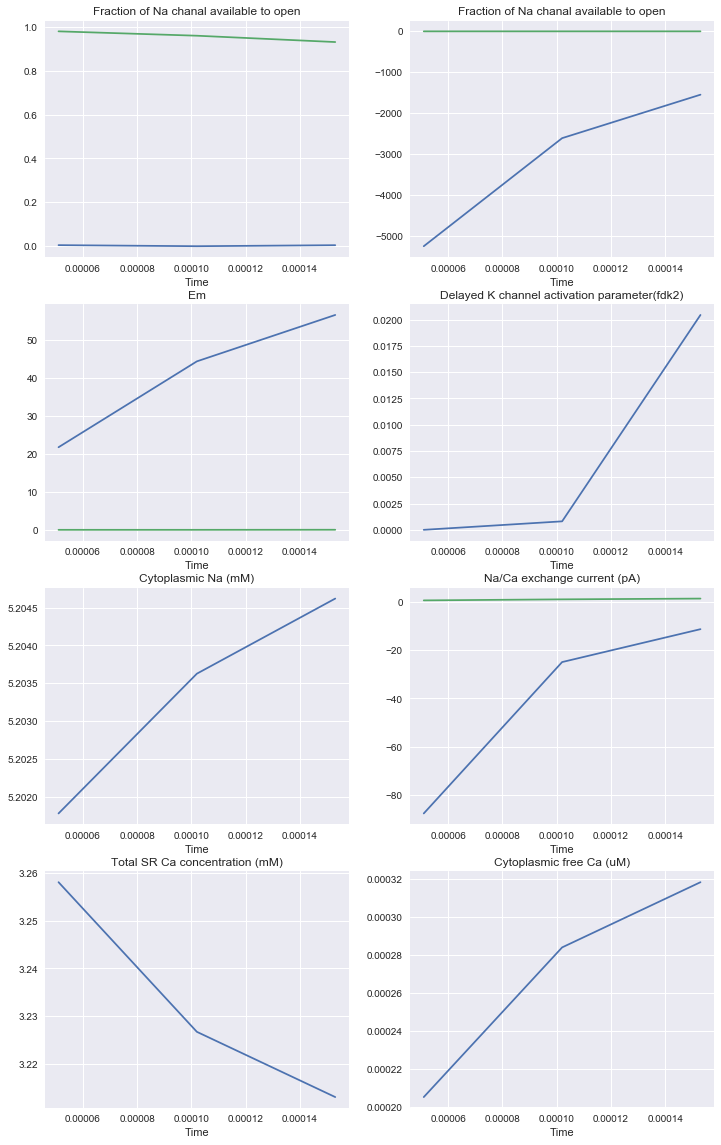

In [13]:
plt.figure(figsize = [12,20])

plt.subplot(4,2,1)
plt.plot(DF['tout'],DF['frout'])
plt.plot(DF['tout'],DF['foout'])
plt.xlabel('Time')
plt.title('Fraction of Na chanal available to open')

plt.subplot(4,2,2)
plt.plot(DF['tout'],DF['inaout'])
plt.plot(DF['tout'],DF['frout'])
plt.xlabel('Time')
plt.title('Fraction of Na chanal available to open')

plt.subplot(4,2,3)
plt.plot(DF['tout'],DF['emout'])
plt.plot(DF['tout'],DF['fdknow'])
plt.xlabel('Time')
plt.title('Em')

plt.subplot(4,2,4)
plt.plot(DF['tout'],DF['fdknow'])
plt.xlabel('Time')
plt.title('Delayed K channel activation parameter(fdk2)')

plt.subplot(4,2,5)
plt.plot(DF['tout'],DF['ninow'])
plt.xlabel('Time')
plt.title('Cytoplasmic Na (mM)')

plt.subplot(4,2,6)
plt.plot(DF['tout'],DF['icanow'])
plt.plot(DF['tout'],DF['incxnow'])
plt.xlabel('Time')
plt.title('Na/Ca exchange current (pA)')

plt.subplot(4,2,7)
plt.plot(DF['tout'],DF['casrnow'])
plt.xlabel('Time')
plt.title('Total SR Ca concentration (mM)')

plt.subplot(4,2,8)
plt.plot(DF['tout'],DF['cinow'])
plt.xlabel('Time')
plt.title('Cytoplasmic free Ca (uM)')

plt.savefig('plot.png')
plt.show()

